# Price Data Exploration

This notebook is an exploration of price/billing data at Komodo. The effort aims at gathering enough insight to produce a model for prices across the encounters map in the hopes of imputing estimates for missing/corrupt data. 

## Notebook Setup and Local Functions

### Import libraries

In [1]:
#basic math/stats/graphs libraries
import numpy as np
from numpy import sqrt, exp, log
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from math import ceil, floor
from ipywidgets import Layout, Button, Box, FloatText, Textarea,Dropdown, Label, IntSlider, Checkbox, interact, interactive
sns.set_style("whitegrid")
import random

In [2]:
#basic model/pandas libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import pandas as pd
from sklearn.linear_model import ElasticNetCV
from datetime import datetime


In [3]:
#install snowflake connector
import sys 
#pull in snowflake login snippets
sys.path.append('/efs/kamalesh')
import jupyter_toolz as jt

Snowflake user name: ········
Password: ········


### Define functions

In [4]:
#generic function to pull in table from snowflake

def pull_snfdb(db='"SANDBOX_KRAO"."EDA"."PROCEDURE_COST_TABLE"',
               select_statement=None, limit=None, where=None, 
               diag=False, sample_n=None):
    
    if select_statement is not None:
        sql=select_statement 
    
    else:
        sql = f"""select * 
         from {db}
        """ 
    if sample_n is not None:
        sql+=f""" sample row ({sample_n} rows) 
        """ 
    if where is not None:
        sql+=f""" where {where} 
        """
    if limit is not None:
        sql+=f""" limit {limit}
        """
    if not diag:
        temp_df=jt.read_sql(sql)
        return temp_df
    else:
        print(sql)
        return sql

#function for summarizing data within snowflake
def pull_snfdb_dist_summ(x='x', db='"SANDBOX_KRAO"."EDA"."PROCEDURE_COST_TABLE"'
                         , name_list=['count','stddev','min', '1percentile', '5percentile',
                                      '10percentile','25percentile',
                                     'average','median','75percentile','90percentile',
                                      '95percentile','99percentile','max']):
    sql = f"""select 
        count(*) as count
        ,stddev({x}) as stddev
        ,min({x}::float) as min
        ,approx_percentile({x}::float,.01) as percentile_1
        ,approx_percentile({x}::float,.05) as percentile_5
        ,approx_percentile({x}::float,.1) as percentile_10
        ,approx_percentile({x}::float,.25) as percentile_25
        ,avg({x}::float) as average
        ,median({x}::float) as median
        ,approx_percentile({x}::float,.75) as percentile_75
        ,approx_percentile({x}::float,.9) as percentile_90
        ,approx_percentile({x}::float,.95) as percentile_95
        ,approx_percentile({x}::float,.99) as percentile_99
         ,max({x}::float) as max
         from {db}
        """ 
    temp_df=jt.read_sql(sql)
    temp_df.columns=[x+'_'+y for y in name_list]
    return temp_df

### Define Databases

In [5]:
#toy data
ahus_mx_db='"SANDBOX_KRAO"."EDA"."TOP_AHUS_HCPS_ENCOUNTERS_W_FLAGS"'


In [6]:
#create pandas data frames for toy data
ahus_mx_df=pull_snfdb(db=ahus_mx_db)

ahus_mx_df["CLAIM_DATE_FORMAT"]=pd.to_datetime(ahus_mx_df["CLAIM_DATE"], errors='coerce')
ahus_mx_df["CLAIM_WEEK"]=ahus_mx_df["CLAIM_DATE_FORMAT"]-pd.to_timedelta(ahus_mx_df["CLAIM_DATE_FORMAT"].dt.weekday, unit="d")

## Inspect Data

In [7]:
ahus_mx_df.head(5).T

,0,1,2,3,4
CLAIM_DATE,2019-09-18,2020-07-20,2019-10-28,2019-08-30,2019-08-30
UPK_KEY2,hMCxzd14jN+AAk3/d42g+KONLY4TJN4OLvUDcggok8w=,RN71JGT/1oD1Cm3mblWKU6BliMcbw/3G55caU/9WUTI=,c85dA675I22kXyHcQlINsOChiQXKj6ZfKx3xUe36ZZQ=,EpZMOnvRdeHnnw93De4zfn+emR5l43Qej0btHoPgiRA=,mmpki8uyiOLJTj0QIRvDoeB2SZ3BFoEkZOhoxw/SblU=
ENCOUNTER_KEY,9a0b91a4a02de608ec350558b06a09c1ec6008a2,f76187b2af33fb474fb0b3010fee4f29903da89a,37ffef9fde85480d34eadcd420729d85ffea01d8,09ff562010142d00d991613598741e82b082220d,659b6d237d826fe1d04345aab45423053b4ff157
HCP_1_NPI,1275512691,1275512691,1275512691,1275512691,1275512691
HCO_1_NPI,1710953286,1922074434,1922074434,1922074434,1922074434
HCP_NPI_ARRAY,"[\n ""1275512691""\n]","[\n ""1275512691""\n]","[\n ""1275512691""\n]","[\n ""1275512691""\n]","[\n ""1275512691""\n]"
HCO_NPI_ARRAY,"[\n ""1710953286""\n]","[\n ""1922074434""\n]","[\n ""1922074434""\n]","[\n ""1922074434""\n]","[\n ""1922074434""\n]"
DIAGNOSIS_ARRAY,"[\n ""D589""\n]","[\n ""Z941""\n]","[\n ""Z940"",\n ""D849"",\n ""Z79899""\n]","[\n ""C9001""\n]","[\n ""D61818""\n]"
PROCEDURE_ARRAY,"[\n ""85025""\n]","[\n ""80195"",\n ""87497""\n]","[\n ""80197"",\n ""87799""\n]","[\n ""81050"",\n ""84156""\n]","[\n ""36415"",\n ""82565"",\n ""85025""\n]"
NDC_ARRAY,None,None,None,None,None


In [20]:
#group by weekly date

ahus_mx_weekly_df=ahus_mx_df.groupby(["HCP_1_NPI", "CLAIM_WEEK"]) \
.agg({'ENCOUNTER_KEY':['count']}) \
.reset_index().droplevel(0, axis=1)
ahus_mx_weekly_df.columns=["HCP", "DATE", "ENCOUNTER_COUNT"]
ahus_mx_weekly_df.sort_values(['HCP','DATE'], inplace=True)


In [21]:
ahus_mx_weekly_df.head(5).T

,0,1,2,3,4
HCP,1003026329,1003026329,1003026329,1003026329,1003026329
DATE,2018-12-31 00:00:00,2019-01-07 00:00:00,2019-01-14 00:00:00,2019-01-21 00:00:00,2019-01-28 00:00:00
ENCOUNTER_COUNT,7,30,39,45,49


In [23]:
ahus_mx_weekly_pivot_df=ahus_mx_weekly_df.pivot(index='DATE', columns='HCP')['ENCOUNTER_COUNT'].reset_index()
ahus_mx_weekly_pivot_df.columns.name = None

In [24]:
ahus_mx_weekly_pivot_df

,DATE,1003026329,1003087388,1003096793,1003809138,1003810938,1003842378,1003868597,1003880378,1003894767,...,1992788574,1992790281,1992790299,1992796767,1992899207,1992908982,1992910954,1992938294,1992951115,1992993406
0,2018-12-31,7.0,2.0,80.0,21.0,201.0,56.0,70.0,21.0,49.0,...,4.0,188.0,69.0,NaN,11.0,NaN,47.0,2.0,39.0,12.0
1,2019-01-07,30.0,123.0,2.0,29.0,51.0,29.0,30.0,47.0,79.0,...,NaN,5.0,120.0,45.0,13.0,61.0,17.0,23.0,14.0,24.0
2,2019-01-14,39.0,3.0,64.0,NaN,58.0,14.0,42.0,48.0,91.0,...,16.0,7.0,66.0,15.0,13.0,31.0,12.0,42.0,110.0,20.0
3,2019-01-21,45.0,4.0,32.0,1.0,31.0,11.0,79.0,38.0,91.0,...,19.0,69.0,30.0,36.0,12.0,45.0,20.0,21.0,41.0,19.0
4,2019-01-28,49.0,124.0,160.0,39.0,212.0,221.0,157.0,45.0,79.0,...,24.0,68.0,151.0,109.0,12.0,28.0,71.0,75.0,166.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2020-11-30,83.0,194.0,141.0,NaN,258.0,142.0,94.0,16.0,88.0,...,21.0,128.0,175.0,142.0,61.0,23.0,49.0,92.0,137.0,93.0
101,2020-12-07,70.0,23.0,12.0,NaN,22.0,36.0,9.0,17.0,81.0,...,NaN,6.0,19.0,18.0,62.0,17.0,22.0,34.0,5.0,82.0
102,2020-12-14,71.0,6.0,35.0,NaN,27.0,16.0,36.0,17.0,87.0,...,9.0,10.0,9.0,9.0,36.0,24.0,20.0,31.0,72.0,65.0
103,2020-12-21,45.0,46.0,24.0,NaN,42.0,2.0,14.0,22.0,55.0,...,22.0,63.0,8.0,NaN,44.0,21.0,2.0,26.0,32.0,28.0


In [30]:
#set up random list of hcps
hcp_list=ahus_mx_df['HCP_1_NPI'].unique()

In [68]:
random_hcps=random.choices(hcp_list, k=3)
random_ahus_weekly_df=ahus_mx_weekly_df[ahus_mx_weekly_df.HCP.isin(random_hcps)].reset_index()
random_ahus_weekly_df['HCP']=random_ahus_weekly_df['HCP'].map(str)


[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

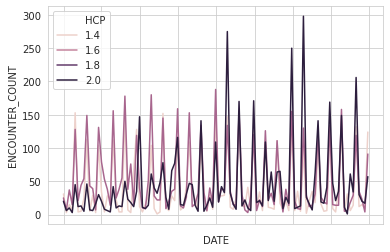

In [69]:
g=sns.lineplot(data=random_ahus_weekly_df, x="DATE", y="ENCOUNTER_COUNT", hue="HCP")
g.set_xticklabels(g.get_xticklabels(), rotation=30)

TO DO:
* Convert to factors?
* Plot Date
* Add Date Cutoff
* Pre/Post Distribution Graph